### KNN 

### Table of Contents

* [1. Preparation](#Preparation)
* [2 Model Building](#modelBuilding)
* [3. Training and Evaluation](#training)
    * [Evaluate with only tokenization 1.1](#tokenization)
    * [Evaluate with stopwords removal](#stopwords_removal)
    * [Evaluate with Stemming](#stemming)
    * [Evaluate with lemmatization](#lemmatization)
    * [Evaluate with Upsampling](#upsampling)
    * [All_but_stemming](#All_but_stemming)
    * [Results](#results)
* [4. Hyperparameter optimization](#tunning)
* [3. Deal with imbalanced classes](#imbalanced)

### 1. Preparation <a class="anchor" id="Preparation"></a>

In [1]:
!pip install datasets

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


In [2]:
!pip install emoji

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


In [3]:
!pip install mlxtend

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


In [4]:
!pip install nltk

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


In [1]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
#from datasets import list_datasets, load_dataset # hugging face dataset
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

import scipy
import random
import torch
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

import os
import glob
import sys
#sys.path.append(os.path.dirname((os.path.abspath(''))))

path = "preprocessing.py"

file_name = os.path.abspath(os.path.join(os.path.dirname( 'data'), '..'))
file_name = os.path.abspath(path)
print(file_name)
#from src.data.preprocessing import setup



import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, TransformerMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from  sklearn.feature_extraction.text import TfidfTransformer
import emoji
SEED = 1234

from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from IPython.core.display import HTML



from datasets import list_datasets, load_dataset
from pprint import pprint

from time import time
import logging
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

C:\Users\D073999\Documents\uni-Mannheim\Data_Mining_I\Data_mining\src\models\preprocessing.py


In [2]:
!pip install demoji

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple


In [3]:

# Just in case the file structure does not make the preprocessing available
import string
from xmlrpc.client import Boolean
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import pandas as pd
import numpy as np
from datasets import load_dataset
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection as ms
from sklearn.utils import resample
import demoji
import re



demoji.download_codes()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


def setup(rem_stop=True, do_stem=True, do_lem=False, split=True, split_on='preprocessed', upsample=True, do_emojis=True):
    df = load_data();
    df['preprocessed'] = preprocess(
        df['tweet'], rem_stop=rem_stop, do_stem=do_stem, do_lem=do_lem, do_emojis=do_emojis)

    tfidf = train_tfidf(df['preprocessed'])

    if split is True:
        df_train, df_test = split_data(df, split_on)
        if upsample is True:
            df_train = upsampling(df_train)
        return tfidf, df_train, df_test
    else:
        return tfidf, df


def load_data():
    dataset = load_dataset("tweets_hate_speech_detection")
    df = pd.DataFrame.from_dict(dataset['train'])
    return df


def preprocess(data, rem_stop=True, do_stem=True, do_lem=False, do_emojis=True):

    preprocessed = []
    for tweet in data:
        if do_emojis is True:
            tweet = convert_emoji(tweet)
        tokens = tokenization(remove_punctuation(tweet))
        if rem_stop is True:
            tokens = remove_stopwords(tokens)
        if do_stem is True and do_lem is False:
            tokens = stemming(tokens)
        if do_lem is True and do_stem is False:
            tokens = lemmatization(tokens)
        preprocessed.append(np.array(tokens))

    return preprocessed


def train_tfidf(data):
    def dummy(text):
        return text

    tf = TfidfVectorizer(
        analyzer='word',
        tokenizer=dummy,
        preprocessor=dummy,
        token_pattern=None)

    return tf.fit(data)


def split_data(df: pd.DataFrame, split_on='tweet', test_size=0.2, random_state=17):
    y = df['label']
    X = df[split_on]
    (X_train, X_test, y_train, y_test) = ms.train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    df_train = pd.concat([y_train, X_train], axis=1)
    df_test = pd.concat([y_test, X_test], axis=1)

    return df_train, df_test


def upsampling(df: pd.DataFrame, replace=True, n_samples=23775, random_state=55):
    data_minority = df[df.label == 1]
    data_majority = df[df.label == 0]
    data_minority = resample(
        data_minority, replace=replace, n_samples=n_samples, random_state=random_state)

    return pd.concat([data_majority, data_minority])


def tokenization(text: str):
    return pd.Series(nltk.word_tokenize(text.lower()))


def remove_punctuation(tokens: pd.Series):
    return "".join([i for i in tokens if i not in punctuation])


def remove_stopwords(tokens: pd.Series):
    stopwords_list = stopwords.words("english")
    return tokens.apply(lambda token: token if token not in stopwords_list and token != '' else None).dropna()


def stemming(tokens: pd.Series):
    stemmer = PorterStemmer()

    return tokens.apply(lambda token: stemmer.stem(token))


def lemmatization(tokens: pd.Series):
    lemmatizer = WordNetLemmatizer()

    return tokens.apply(lambda token: lemmatizer.lemmatize(token))


def convert_emoji(text: str) -> str:
    # convert string to binary representation
    binary = ' '.join(format(ord(x), 'b') for x in text)

    # convert binary representation to utf8 representation
    listRes = list(binary.split(" "))
    try:
        text_with_emoji = bytes([int(x, 2) for x in listRes]).decode('utf-8')
    except UnicodeDecodeError:
        return text

    # get all emojis
    dictionary = demoji.findall(text_with_emoji)

    # replace emojis with text representation
    for key in dictionary.keys():
        text_with_emoji = text_with_emoji.replace(key, dictionary[key] + " ")

    return text_with_emoji


def get_features(df: pd.DataFrame):
    df["n_mentions"] = df["tweet"].apply(lambda x: count_user_mentions(x))
    df["hashtags"] = df["tweet"].apply(lambda x: identify_hashtags(x))

    return df

def count_user_mentions(text:str) ->int:
    return text.count("@user")

def identify_hashtags(text:str) -> list:
    pattern = re.compile(r"#(\w+)")
    return pattern.findall(text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\D073999\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\D073999\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\D073999\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import sys  
sys.path.insert(0, 'C:\\Users\\D073999\\Documents\\uni-Mannheim\\Data_Mining_I\\Data_mining\\src\\data')

#from preprocessing import preprocess,load_data, tokenization, remove_punctuation, convert_emoji, setup
#from src.data import preprocessing

# 2. Model Building <a class="anchor" id="modelBuilding"></a>

In [6]:
import functools
import time


def time_decorater(function):

    @functools.wraps(function)
    def time_measurement(*args, **kwargs):
        start = time.perf_counter()
        result = function(*args, **kwargs)
        end = time.perf_counter()
        print("function: {} finished in {} seconds.".format(repr(function.__name__), round((end - start), 2)))
        return result

    return time_measurement

In [7]:
class KNN_DM(BaseEstimator, ClassifierMixin):
    
    def __init__(self,
                 n_neighbors=3,
                 algorithm='auto',
                 metric='minkowski',
                 p=2,
                 weights='distance',
                 metric_params=None):
        
                self.n_neighbors = n_neighbors
                self.algorithm = algorithm
                self.metric = metric
                self.metric_params = metric_params
                self.p = p
                self.weights = weights

                #self.cv = cv,
                #self.n_jobs = n_jobs,
                #self.verbose = verbose
                
    
    def __get_pipeline(self):
        
            classifier = KNeighborsClassifier(**{
                'n_neighbors': self.n_neighbors
            })
            
            # pipeline steps
            steps=[
                #("vect",  CountVectorizer()),
                #("tfidf", TfidfTransformer()),
                ('clf', classifier)]

            self.pipeline = Pipeline(steps=steps)
            return self.pipeline
    
    
    def __get_model(self, feature_range, n_estimators, X, y): 
        
        self.parameters = {
                'clf__n_neighbors': n_estimators,                                   
                'clf__algorithm': ['ball_tree',  'auto'],    #'kd_tree',      
                'clf__metric': ['euclidean', 'manhattan']
        }
        """self.parameters = {
                'clf__n_neighbors': n_estimators.
                'clf__metric': ['l1', 'l2']
        }"""
        grid_search = GridSearchCV(**{
                'estimator': self.__get_pipeline(),
                'cv': 5,
                'param_grid': self.parameters,
                'scoring': 'f1',#{'F1': 'f1', 'Precision': 'precision', 'Recall':'recall'},
                 'refit': True,
                'verbose': 5,
                 'n_jobs': -1
            })
        return grid_search
    
    @time_decorater
    def fit(self, X, y, optim):
        if scipy.sparse.issparse(X):
            warnings.warn("KNN Can no fit sparse matrix. The matrix will be converted to an array")
            X = X.toarray()
        print(100* '-')
        
        if y is None:
                raise ValueError('requires y to be passed, but the target y is None')
        self.y_train = y
        
        X, y = check_X_y(X, y)
        self.is_fitted_ = True
        if optim:
            display(HTML("<h4>[1/5] Started Hyperparameter optimazation...</h4>"))
            self.model_ = self.__get_model(feature_range=None, n_estimators =[3,5,10], X =X, y=y) #np.arange(1, 21)
            print("Performing grid search...")
            print("pipeline:", [name for name, _ in self.pipeline.steps])
            print("parameters:")
            pprint(self.parameters)
            #t0 = time()
            self.model_.fit(X, y)
            #print("done in %0.3fs" % (time() - t0))
            print("Done")
            print()

            print("Best score: %0.3f" % self.model_.best_score_)
            print("Best parameters set:")
            best_parameters = self.model_.best_estimator_.get_params()
            for param_name in sorted(self.parameters.keys()):
                print("\t%s: %r" % (param_name, best_parameters[param_name]))
        else:
            display(HTML("<h4>[1/5] Started Fitting...</h4>"))
            # if not opt true, create knn with default 3 neigh.
            self.model_  = KNeighborsClassifier(**{
                    'n_neighbors': 3
                })

            self.model_ .fit(X, y)
        print()
        return self
            
    @time_decorater        
    def predict(self, X, y=None):
        if scipy.sparse.issparse(X):
            warnings.warn("KNN Can no fit sparse matrix. The matrix will be converted to an array")
            X = X.toarray()
        print(100* '-')
        display(HTML("<h4>[2/5] Started Prediction...</h4>"))
        self.y_test = y
        #check_is_fitted(self, ['is_fitted_', 'model_'])
        X = check_array(X)
        self.y_pred = self.model_.predict(X)
        print("head of y_pred is \t%s: " % (self.y_pred[0:6]))
    
    @time_decorater
    def predict_proba(self, X, y=None):
        if scipy.sparse.issparse(X):
            warnings.warn("KNN Can no fit sparse matrix. The matrix will be converted to an array")
            X = X.toarray()
        print(100* '-')
        display(HTML("<h4>Started Predicting Model confidence...</h4>"))
        print()
        return self.model_ .predict_propa(X, y)
     
    @time_decorater
    def evaluate(self, title = "KNN Classifier on Test Set"):
        print(100* '-')
        display(HTML("<h4>[3/5] Started Evaluation...</h4>"))
     
        f1 = f1_score(self.y_test, self.y_pred)
        accuracy = accuracy_score(self.y_test, self.y_pred)*100
        recall = recall_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred)
        
        #scores
        print("f1-score:         \t%s " % (f1))
        print("accuracy-score:   \t%s " % (accuracy))
        print("precision-score:  \t%s " % (precision))
        print("recall-score:     \t%s " % (recall))
        print()
        self.report = self.print_report(self.y_test, self.y_pred)
        cm = confusion_matrix(self.y_test, self.y_pred)
        self.__plot_confusion_matrix(cm, unique_labels(self.y_test),  title = title) #classes = np.unique(y_train),
        
        return self.report, accuracy, recall, precision, f1
    
    @staticmethod
    @time_decorater  
    def print_report(y_test, y_pred):
        print(100* '-')
        display(HTML("<h4>[4/5] Started creating a report...</h4>"))
        report = classification_report(y_test, y_pred, output_dict=True)
        report = pd.DataFrame(report).transpose()
        display(report)
        print()
        return report
        
    @staticmethod   
    @time_decorater   
    def __plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        print(100* '-')
        display(HTML("<h4>[5/5] Started plotting the confusion matrix...</h4>"))
        print("Start plotting the confusion matrix...\n")
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

# 3. Training & Evaluation  <a class="anchor" id="training"></a>

### try differnt steps to find the best ones to choosse
accroding to previous tries, removing the emoji have a positive effect to the accuracy
so, this step will not be perfromed. 
follows the steps will be performed:

1- tokenization

2- stopwords removal

3- stemming 

4- upsampling

In [11]:
results_tf = []
results_cv = []
results_tf_train = []
results_cv_train = []

### Helper functions

In [8]:
def featureize(rem_stop=False, do_stem=False, do_lem=False, split=True, upsample=False, do_emojis=False):

    _, df_train, df_test = setup(rem_stop=rem_stop, do_stem=do_stem, do_lem=do_lem, split=True, upsample=False, do_emojis=False); df_train
    X_train = df_train['preprocessed']
    y_train= df_train['label']
    X_test = df_test['preprocessed']
    y_test = df_test['label']
    print(f'X_train: {len(X_train)}, X_test: {len(X_test)}')
    return X_train, X_test, y_train, y_test

In [9]:
def convert_to_tf_idf(X_train, X_test):
    
    count_vect = CountVectorizer(stop_words='english')
    transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
    xd = pd.Series(np.array(X_train).flatten())
    text = xd.map(' '.join)
    x_train_counts = count_vect.fit_transform(text)
    x_train_tfidf = transformer.fit_transform(x_train_counts)
    print(x_train_counts.shape)
    print(x_train_tfidf.shape)
    #Output :(25569, 27304) (25569, 27304)
    text = X_test.map(' '.join)
    x_test_counts = count_vect.transform(text)
    x_test_tfidf = transformer.transform(x_test_counts)
    print(x_test_counts.shape)
    print(x_test_tfidf.shape)
    return x_train_tfidf, x_test_tfidf, x_train_counts, x_test_counts   

# 1. With only Tokenization <a class="anchor" id="tokenization"></a>

In [15]:
X_train, X_test, y_train, y_test = featureize(rem_stop=False,
                                              do_stem=False,
                                              do_lem=False,
                                              split=True,
                                              upsample=False,
                                              do_emojis=False)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

2022-05-25 16:25:32,970 WARNING Using custom data configuration default
2022-05-25 16:25:32,992 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 37441)
(25569, 37441)
(6393, 37441)
(6393, 37441)


<25569x37441 sparse matrix of type '<class 'numpy.float64'>'
	with 190446 stored elements in Compressed Sparse Row format>

## 1.1. Using TF-IDF

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 5.43 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 94.27 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3082706766917293 
accuracy-score:   	94.24370405130612 
precision-score:  	0.9761904761904762 
recall-score:     	0.18303571428571427 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.941988  0.999664  0.969969  5945.000000
1              0.976190  0.183036  0.308271   448.000000
accuracy       0.942437  0.942437  0.942437     0.942437
macro avg      0.959089  0.591350  0.639120  6393.000000
weighted avg   0.944384  0.942437  0.923599  6393.000000


function: 'print_report' finished in 0.03 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.1 seconds.
function: 'evaluate' finished in 0.14 seconds.



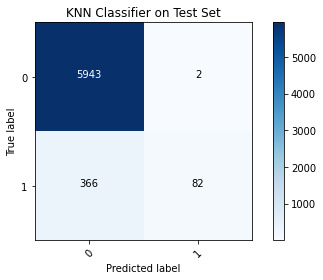

In [57]:
knn = KNN_DM()
model = knn.fit(X_train, y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()

method = "only tokenization"
results_tf.append({
                'method':"tokenization",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            }) #, ignore_index=True
print()

## 1.2 Using Count-Vectroizer

 ### classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 0.01 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 125.53 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.33271719038817005 
accuracy-score:   	94.35319881119975 
precision-score:  	0.967741935483871 
recall-score:     	0.20089285714285715 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.943175  0.999495  0.970519  5945.000000
1              0.967742  0.200893  0.332717   448.000000
accuracy       0.943532  0.943532  0.943532     0.943532
macro avg      0.955458  0.600194  0.651618  6393.000000
weighted avg   0.944896  0.943532  0.925824  6393.000000


function: 'print_report' finished in 0.06 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 2.72 seconds.
function: 'evaluate' finished in 2.83 seconds.



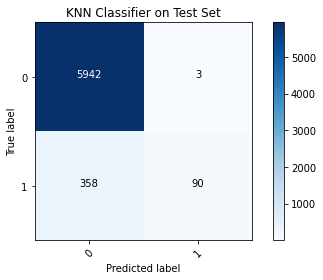

In [58]:
knn = KNN_DM()
model = knn.fit(X_train_c.toarray(), y_train, optim=False)
y_pred = model.predict(X_test_c.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"tokenization",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# 1.3 with hyperparameteroptimization 

In [16]:
# this step was added after doing hyperparameter opt. so only the report will be given out
# no adoption to the template class is made

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors= 2, p=2, weights='distance') #use 
model = knn.fit(X_train_c.toarray(), y_train)
y_pred = model.predict(X_test_c.toarray())
report = classification_report(y_test, y_pred, output_dict=True)
print(report)

{'0': {'precision': 0.9543041029766693, 'recall': 0.9976450798990748, 'f1-score': 0.9754934210526315, 'support': 5945}, '1': {'precision': 0.9213483146067416, 'recall': 0.36607142857142855, 'f1-score': 0.5239616613418531, 'support': 448}, 'accuracy': 0.9533865165024246, 'macro avg': {'precision': 0.9378262087917055, 'recall': 0.6818582542352517, 'f1-score': 0.7497275411972423, 'support': 6393}, 'weighted avg': {'precision': 0.9519946718504801, 'recall': 0.9533865165024246, 'f1-score': 0.9438515896197474, 'support': 6393}}


# 2 with only Removing Stopwords <a class="anchor" id="stopwords_removal"></a>

### vectorize with tfidf countvectorizer
   

In [59]:
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=False,
                                              do_lem=False, 
                                              split=True,
                                              upsample=False,
                                              do_emojis=False)

X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

2022-05-22 12:02:43,664 WARNING Using custom data configuration default
2022-05-22 12:02:43,679 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 37433)
(25569, 37433)
(6393, 37433)
(6393, 37433)


<25569x37433 sparse matrix of type '<class 'numpy.float64'>'
	with 188772 stored elements in Compressed Sparse Row format>

## 2.1 Using TF-IDF

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 5.16 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 94.25 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.30769230769230765 
accuracy-score:   	94.22806194274989 
precision-score:  	0.9647058823529412 
recall-score:     	0.18303571428571427 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.941978  0.999495  0.969885  5945.000000
1              0.964706  0.183036  0.307692   448.000000
accuracy       0.942281  0.942281  0.942281     0.942281
macro avg      0.953342  0.591266  0.638789  6393.000000
weighted avg   0.943571  0.942281  0.923481  6393.000000


function: 'print_report' finished in 0.02 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.08 seconds.
function: 'evaluate' finished in 0.12 seconds.



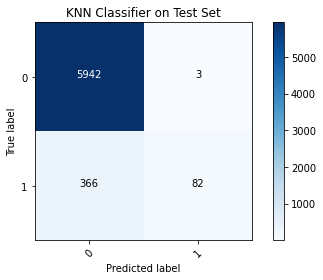

In [60]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_tf.append({
                'method':"Stopwords removal",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

## 2.2 Using Count-Vectroizer

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 0.0 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 127.16 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.33149171270718236 
accuracy-score:   	94.32191459408729 
precision-score:  	0.9473684210526315 
recall-score:     	0.20089285714285715 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.943157  0.999159  0.970350  5945.000000
1              0.947368  0.200893  0.331492   448.000000
accuracy       0.943219  0.943219  0.943219     0.943219
macro avg      0.945262  0.600026  0.650921  6393.000000
weighted avg   0.943452  0.943219  0.925581  6393.000000


function: 'print_report' finished in 0.07 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.25 seconds.
function: 'evaluate' finished in 0.37 seconds.



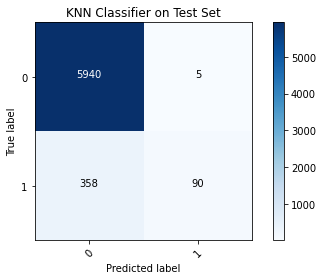

In [61]:
knn = KNN_DM()
model = knn.fit(X_train_c.toarray(), y_train, optim=False)
y_pred = model.predict(X_test_c.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"Stopwords removal",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# 3 with  Stemming <a class="anchor" id="stemming"></a>

### vectorize with tfidf countvectorizer

In [62]:
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=False,
                                              do_emojis=False)

X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

2022-05-22 12:07:34,190 WARNING Using custom data configuration default
2022-05-22 12:07:34,219 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)


<25569x32129 sparse matrix of type '<class 'numpy.float64'>'
	with 188128 stored elements in Compressed Sparse Row format>

## 3.1 Using TF-IDF

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 5.49 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 87.56 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3108614232209738 
accuracy-score:   	94.24370405130612 
precision-score:  	0.9651162790697675 
recall-score:     	0.18526785714285715 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.942128  0.999495  0.969964  5945.000000
1              0.965116  0.185268  0.310861   448.000000
accuracy       0.942437  0.942437  0.942437     0.942437
macro avg      0.953622  0.592382  0.640413  6393.000000
weighted avg   0.943739  0.942437  0.923776  6393.000000


function: 'print_report' finished in 0.03 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.1 seconds.
function: 'evaluate' finished in 0.15 seconds.



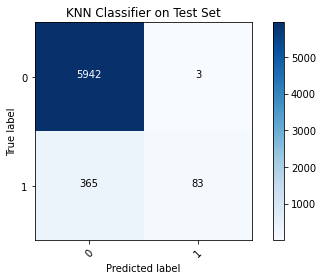

In [63]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_tf.append({
                'method':"Stemming",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

## 3 .2 Using Count-Vectroizer

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 0.01 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 116.75 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3460837887067395 
accuracy-score:   	94.38448302831222 
precision-score:  	0.9405940594059405 
recall-score:     	0.21205357142857142 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.943897  0.998991  0.970663  5945.000000
1              0.940594  0.212054  0.346084   448.000000
accuracy       0.943845  0.943845  0.943845     0.943845
macro avg      0.942246  0.605522  0.658373  6393.000000
weighted avg   0.943666  0.943845  0.926894  6393.000000


function: 'print_report' finished in 0.06 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.21 seconds.
function: 'evaluate' finished in 0.31 seconds.



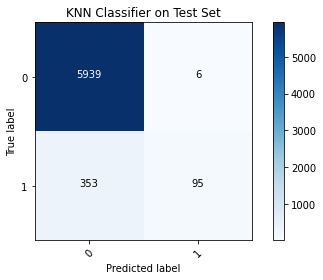

In [64]:
knn = KNN_DM()
model = knn.fit(X_train_c.toarray(), y_train, optim=False)
y_pred = model.predict(X_test_c.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"Stemming",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# 4 with Lemmatization <a class="anchor" id="lemmatization"></a>

In [65]:

X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=False,
                                              do_lem=True, 
                                              split=True,
                                              upsample=False,
                                              do_emojis=False)
#vectorize
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

2022-05-22 12:12:26,746 WARNING Using custom data configuration default
2022-05-22 12:12:26,762 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 35354)
(25569, 35354)
(6393, 35354)
(6393, 35354)


<25569x35354 sparse matrix of type '<class 'numpy.float64'>'
	with 187357 stored elements in Compressed Sparse Row format>

## 4.1 Using TF-IDF

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 4.76 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 88.27 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3146067415730337 
accuracy-score:   	94.27498826841858 
precision-score:  	0.9767441860465116 
recall-score:     	0.1875 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score     support
0              0.942286  0.999664  0.970127  5945.00000
1              0.976744  0.187500  0.314607   448.00000
accuracy       0.942750  0.942750  0.942750     0.94275
macro avg      0.959515  0.593582  0.642367  6393.00000
weighted avg   0.944701  0.942750  0.924191  6393.00000


function: 'print_report' finished in 0.02 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.09 seconds.
function: 'evaluate' finished in 0.13 seconds.



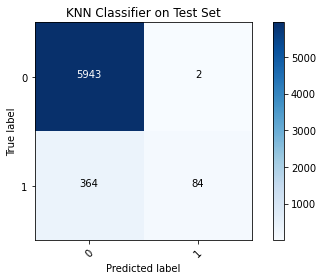

In [66]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_tf.append({
                'method':"lemmitization",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

## 4 .2 Using Count-Vectroizer

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 0.01 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 134.6 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3387978142076503 
accuracy-score:   	94.32191459408729 
precision-score:  	0.9207920792079208 
recall-score:     	0.20758928571428573 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.943579  0.998654  0.970336  5945.000000
1              0.920792  0.207589  0.338798   448.000000
accuracy       0.943219  0.943219  0.943219     0.943219
macro avg      0.932186  0.603122  0.654567  6393.000000
weighted avg   0.941982  0.943219  0.926080  6393.000000


function: 'print_report' finished in 0.06 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.21 seconds.
function: 'evaluate' finished in 0.33 seconds.



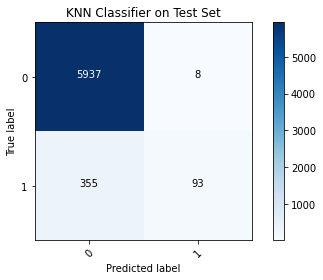

In [67]:
knn = KNN_DM()
model = knn.fit(X_train_c.toarray(), y_train, optim=False)
y_pred = model.predict(X_test_c.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"lemmitization",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# 5 with Upsampling <a class="anchor" id="upsampling"></a>

In [68]:
# best results were achieved after the stemming/lemma and count_vectorizer therefore this will be upsampled
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=False)

2022-05-22 12:17:23,116 WARNING Using custom data configuration default
2022-05-22 12:17:23,132 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393


### vectorize with tfidf countvectorizer

In [69]:
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)


<25569x32129 sparse matrix of type '<class 'numpy.float64'>'
	with 188128 stored elements in Compressed Sparse Row format>

## 5.1 Using TF-IDF

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 4.76 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 81.94 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3108614232209738 
accuracy-score:   	94.24370405130612 
precision-score:  	0.9651162790697675 
recall-score:     	0.18526785714285715 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.942128  0.999495  0.969964  5945.000000
1              0.965116  0.185268  0.310861   448.000000
accuracy       0.942437  0.942437  0.942437     0.942437
macro avg      0.953622  0.592382  0.640413  6393.000000
weighted avg   0.943739  0.942437  0.923776  6393.000000


function: 'print_report' finished in 0.03 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.1 seconds.
function: 'evaluate' finished in 0.14 seconds.



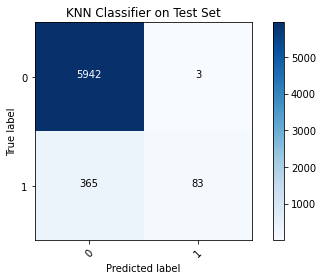

In [70]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_tf.append({
                'method':"Upsampling",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

## 5 .2 Using Count-Vectroizer

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 0.0 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 111.77 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.3460837887067395 
accuracy-score:   	94.38448302831222 
precision-score:  	0.9405940594059405 
recall-score:     	0.21205357142857142 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.943897  0.998991  0.970663  5945.000000
1              0.940594  0.212054  0.346084   448.000000
accuracy       0.943845  0.943845  0.943845     0.943845
macro avg      0.942246  0.605522  0.658373  6393.000000
weighted avg   0.943666  0.943845  0.926894  6393.000000


function: 'print_report' finished in 0.07 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.27 seconds.
function: 'evaluate' finished in 0.4 seconds.



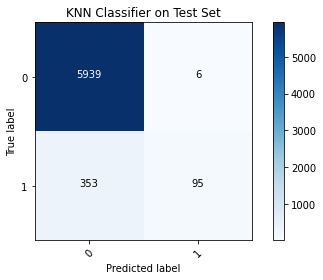

In [71]:
knn = KNN_DM()
model = knn.fit(X_train_c.toarray(), y_train, optim=False)
y_pred = model.predict(X_test_c.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"Upsampling",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# 6 All_but_setemming <a class="anchor" id="All_but_stemming"></a>

In [25]:
# best results were achieved after the stemming/lemma and count_vectorizer therefore this will be upsampled
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=False,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=True)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

2022-05-23 11:44:14,351 WARNING Using custom data configuration default
2022-05-23 11:44:14,367 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 37433)
(25569, 37433)
(6393, 37433)
(6393, 37433)


<25569x37433 sparse matrix of type '<class 'numpy.float64'>'
	with 188772 stored elements in Compressed Sparse Row format>

## 6.1 Using TF-IDF

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 4.96 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 91.74 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.30769230769230765 
accuracy-score:   	94.22806194274989 
precision-score:  	0.9647058823529412 
recall-score:     	0.18303571428571427 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.941978  0.999495  0.969885  5945.000000
1              0.964706  0.183036  0.307692   448.000000
accuracy       0.942281  0.942281  0.942281     0.942281
macro avg      0.953342  0.591266  0.638789  6393.000000
weighted avg   0.943571  0.942281  0.923481  6393.000000


function: 'print_report' finished in 0.02 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.08 seconds.
function: 'evaluate' finished in 0.12 seconds.



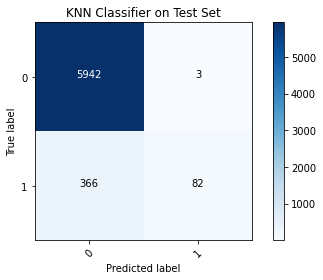

In [73]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_tf.append({
                'method':"All_but_stemming",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

## 6 .2 Using Count-Vectroizer

###  classification, Evaluation & plotting with only tokenization

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 7.73 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 

function: 'predict' finished in 98.13 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.30769230769230765 
accuracy-score:   	94.22806194274989 
precision-score:  	0.9647058823529412 
recall-score:     	0.18303571428571427 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.941978  0.999495  0.969885  5945.000000
1              0.964706  0.183036  0.307692   448.000000
accuracy       0.942281  0.942281  0.942281     0.942281
macro avg      0.953342  0.591266  0.638789  6393.000000
weighted avg   0.943571  0.942281  0.923481  6393.000000


function: 'print_report' finished in 0.04 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.12 seconds.
function: 'evaluate' finished in 0.18 seconds.



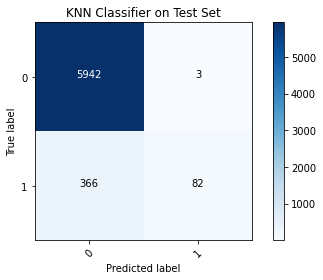

In [74]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"All_but_stemming",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# 7 Only remove Emojis <a class="anchor" id="rmoji"></a>

In [30]:
# best results were achieved after the stemming/lemma and count_vectorizer therefore this will be upsampled
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=False,
                                              do_lem=False, 
                                              split=True,
                                              upsample=False,
                                              do_emojis=True)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

2022-05-26 09:29:14,945 WARNING Using custom data configuration default
2022-05-26 09:29:14,969 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 37433)
(25569, 37433)
(6393, 37433)
(6393, 37433)


<25569x37433 sparse matrix of type '<class 'numpy.float64'>'
	with 188772 stored elements in Compressed Sparse Row format>

----------------------------------------------------------------------------------------------------



function: 'fit' finished in 4.12 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 
function: 'predict' finished in 52.62 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.30769230769230765 
accuracy-score:   	94.22806194274989 
precision-score:  	0.9647058823529412 
recall-score:     	0.18303571428571427 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.941978  0.999495  0.969885  5945.000000
1              0.964706  0.183036  0.307692   448.000000
accuracy       0.942281  0.942281  0.942281     0.942281
macro avg      0.953342  0.591266  0.638789  6393.000000
weighted avg   0.943571  0.942281  0.923481  6393.000000


function: 'print_report' finished in 0.05 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.13 seconds.
function: 'evaluate' finished in 0.2 seconds.



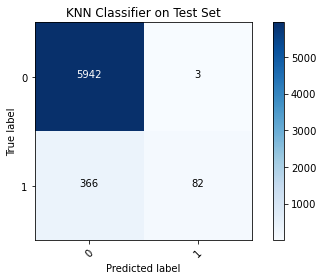

In [33]:
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
results_cv.append({
                'method':"All_but_stemming",
                'accuracy': accuracy,
                "recall": recall,
                "precision": precision,
                "f1": f1
            })
print()

# Results <a class="anchor" id="results"></a>

In [75]:
results_tf = pd.DataFrame(results_tf)
results_cv = pd.DataFrame(results_cv)

In [76]:
display(HTML("<h2> Results using TF-IDF</h2>"))
display(results_tf)
print()
display(HTML("<h2> Results using Countervectorizer</h2>"))
display(results_cv)

method   accuracy    recall  precision        f1
0       tokenization  94.243704  0.183036   0.976190  0.308271
1  Stopwords removal  94.228062  0.183036   0.964706  0.307692
2           Stemming  94.243704  0.185268   0.965116  0.310861
3      lemmitization  94.274988  0.187500   0.976744  0.314607
4         Upsampling  94.243704  0.185268   0.965116  0.310861
5   All_but_stemming  94.228062  0.183036   0.964706  0.307692

method   accuracy    recall  precision        f1
0       tokenization  94.353199  0.200893   0.967742  0.332717
1  Stopwords removal  94.321915  0.200893   0.947368  0.331492
2           Stemming  94.384483  0.212054   0.940594  0.346084
3      lemmitization  94.321915  0.207589   0.920792  0.338798
4         Upsampling  94.384483  0.212054   0.940594  0.346084
5   All_but_stemming  94.228062  0.183036   0.964706  0.307692

2022-05-22 12:47:56,205 WARNING Using custom data configuration default
2022-05-22 12:47:56,212 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)
----------------------------------------------------------------------------------------------------



function: 'fit' finished in 9.98 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[0 0 0 0 0 0]: 
f1-score:         	0.5181219110378913 
accuracy-score:   	95.42414642731433 
precision-score:  	0.9921135646687698 
recall-score:     	0.35061315496098105 

function: 'predict' finished in 354.7 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.5181219110378913 
accuracy-score:   	95.42414642731433 
precision-score:  	0.9921135646687698 
recall-score:     	0.35061315496098105 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score       support
0              0.953279  0.999790  0.975980  23775.000000
1              0.992114  0.350613  0.518122   1794.000000
accuracy       0.954241  0.954241  0.954241      0.954241
macro avg      0.972696  0.675201  0.747051  25569.000000
weighted avg   0.956003  0.954241  0.943856  25569.000000


function: 'print_report' finished in 0.16 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.34 seconds.
function: 'evaluate' finished in 0.57 seconds.



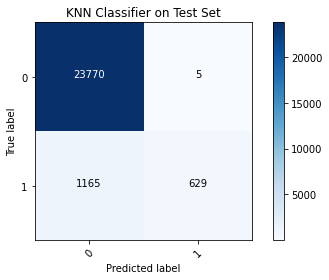

In [83]:
# best results were achieved after the stemming/lemma and upsampling and counvectorizer
#check train and test error
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=False)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train
knn = KNN_DM()
model = knn.fit(X_train.toarray(), y_train, optim=False)
y_pred = model.predict(X_train.toarray(), y_train)
report, accuracy, recall, precision, f1 = model.evaluate()
print()

# Hyperparameter optimization <a class="anchor" id="tunning"></a>

In [95]:
#switch to the original knn, because some metric are not included in knn_dm e.x p
knn = KNeighborsClassifier()

In [96]:

param_grid = [
  {'n_neighbors': [2,3,5,10,30], 'weights': ['uniform','distance'], 'algorithm':['ball_tree','kd_tree'], 'p':[1,2,5]},
  {'n_neighbors': [2,3,5,10,30], 'weights': ['uniform','distance'], 'algorithm':['brute'], 'p':[1,2,5]},
 ]

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator = GridSearchCV(knn, param_grid, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(X_train_c, y_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 90 candidates, totalling 900 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.057900      0.065501         8.318176        0.455068   
1        0.058199      0.032361         9.119041        0.615112   
2        0.046799      0.034180         3.484859        0.393268   
3        0.042099      0.019036         3.525557        0.379054   
4        0.119299      0.147243         0.000000        0.000000   
..            ...           ...              ...             ...   
85       0.007801      0.003092         8.663470        0.392306   
86       0.013300      0.004797         3.765271        0.228174   
87       0.013800      0.006523         3.543843        0.420425   
88       0.010198      0.002137         0.000000        0.000000   
89       0.011700      0.005001         0.000000        0.000000   

   param_algorithm param_n_neighbors param_p param_weights  \
0        ball_tree                 2       1       uniform   
1        ball_tree                 2       1      distance   
2        ball_tree                 2       2       uniform   
3        ball_tree                 2       2      distance   
4        ball_tree                 2       5       uniform   
..             ...               ...     ...           ...   
85           brute                30       1      distance   
86           brute                30       2       uniform   
87           brute                30       2      distance   
88           brute                30       5       uniform   
89           brute                30       5      distance   

                                               params  split0_test_score  ...  \
0   {'algorithm': 'ball_tree', 'n_neighbors': 2, '...           0.614845  ...   
1   {'algorithm': 'ball_tree', 'n_neighbors': 2, '...           0.719129  ...   
2   {'algorithm': 'ball_tree', 'n_neighbors': 2, '...           0.623364  ...   
3   {'algorithm': 'ball_tree', 'n_neighbors': 2, '...           0.717006  ...   
4   {'algorithm': 'ball_tree', 'n_neighbors': 2, '...                NaN  ...   
..                                                ...                ...  ...   
85  {'algorithm': 'brute', 'n_neighbors': 30, 'p':...           0.597982  ...   
86  {'algorithm': 'brute', 'n_neighbors': 30, 'p':...           0.530259  ...   
87  {'algorithm': 'brute', 'n_neighbors': 30, 'p':...           0.597982  ...   
88  {'algorithm': 'brute', 'n_neighbors': 30, 'p':...                NaN  ...   
89  {'algorithm': 'brute', 'n_neighbors': 30, 'p':...                NaN  ...   

    split3_test_score  split4_test_score  split5_test_score  \
0            0.671316           0.643981           0.635034   
1            0.749564           0.727706           0.717006   
2            0.676896           0.660719           0.643136   
3            0.763250           0.731928           0.717106   
4                 NaN                NaN                NaN   
..                ...                ...                ...   
85           0.632529           0.652847           0.619124   
86           0.570265           0.574999           0.540427   
87           0.636668           0.644832           0.619124   
88                NaN                NaN                NaN   
89                NaN                NaN                NaN   

    split6_test_score  split7_test_score  split8_test_score  \
0            0.646281           0.635848           0.635848   
1            0.745050           0.747291           0.691083   
2            0.646281           0.643136           0.639933   
3            0.735747           0.746922           0.697766   
4                 NaN                NaN                NaN   
..                ...                ...                ...   
85           0.627564           0.623364           0.614845   
86           0.550389           0.550389           0.529903   
87           0.619124           0.610525           0.601082   
88                NaN                NaN                NaN   
89                N

best score is 0.7334156145167383 with params {'algorithm': 'ball_tree', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}


In [42]:
# check improvment of hyperparameter opti. 
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=False)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors= 2, p=2, weights='distance')
model = knn.fit(X_train_c, y_train)

y_pred = model.predict(X_test_c.toarray())
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
display(report)

2022-05-26 11:22:44,678 WARNING Using custom data configuration default
2022-05-26 11:22:44,685 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)


precision    recall  f1-score      support
0              0.954707  0.996299  0.975060  5945.000000
1              0.883598  0.372768  0.524333   448.000000
accuracy       0.952604  0.952604  0.952604     0.952604
macro avg      0.919152  0.684534  0.749696  6393.000000
weighted avg   0.949724  0.952604  0.943474  6393.000000

In [101]:
f1 = f1_score(y_test, y_pred);f1

0.5243328100470959

In [44]:
print("f1: ", f1_score(y_test, y_pred))
print("recall: ", recall_score(y_test, y_pred))
print("precision", precision_score(y_test, y_pred))

f1:  0.5243328100470959
recall:  0.37276785714285715
precision 0.8835978835978836


In [41]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


# create the classifier
model1 = KNeighborsClassifier(algorithm='ball_tree', n_neighbors= 2, p=2, weights='distance')

# fit model
model1.fit(X_train, y_train)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)

In [42]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [43]:
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])

print(auc_score1)

0.6918135362849935


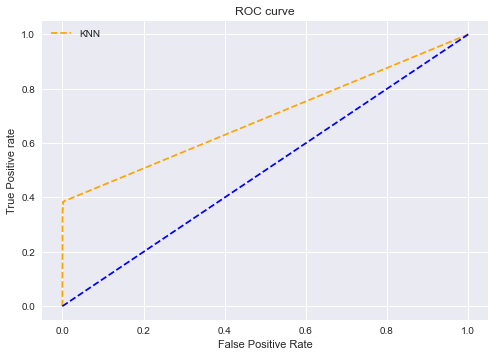

In [44]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

the best score achieved after hyperparameter optimization

### choose value of k

this step was done before grid search above and the k value was chosen independent from other hyperparameter (no interaction). This value could change if we performed grid-search where the interaction between other parameters can make some difference

In [133]:
accuracy_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn, X_train_c, y_train,cv=10)
    accuracy_rate.append(score.mean())

Text(0, 0.5, 'Accuracy Rate')

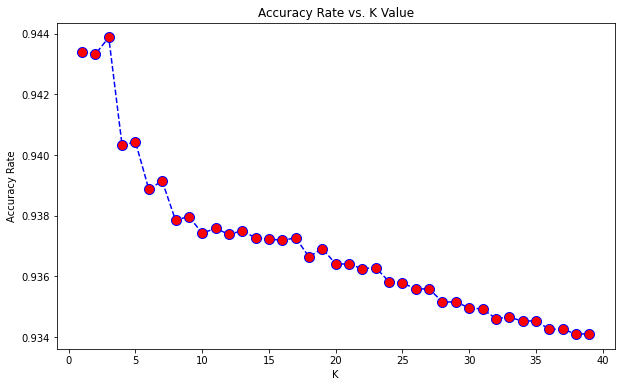

In [138]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

One can see, that is the accuracy is very high, between 2 and 5, wheras it reaches the peak at around 3, after 20 
the accuracy keeps dropping down

# Impalanced classes <a class="anchor" id="imbalanced"></a>

F1-score is very low, In this section we just use the default classifier without using the optimal hyperparameter settings
to be able to distinguish, if the f1 increased because of this mehtod or  not
try to find tech. that specifically target the f-1 (like ensambles targets  overfitting).
the idea is rather to deal with imbalanced classes and not directly the f1-score, but as a result of handling the 
imbalance state in the right way, the f1-score should also be boosted:

1- use Ensembles or balanced-bagging-classifier: this is a rather simple solution and redandant, it is a normal classifier
but it will resample the data without having to use a sampler, so the results should be the same as if one resampled and then used another normal classifier

2- Resampling like resample from sklearn: already used above

3- SMOTE Synthetic Minority Oversampling Technique: oversampling the minor class by creating synthetic examples
    form original data and not only deleting or duplicating the examples
    
4- Threshold moving: most of the learners in sklearn have predict_proba, which give a probabillity 

### balanced-bagging-classifier

wisdom of the crowd
it uses multiple classifiers and at the end use a vote to choose best prediction

In [45]:
from imblearn.ensemble import BalancedBaggingClassifier
# KNeighborsClassifier
# KNN_DM is just a convient way to reuse the code, it will not work on all cases, because, 
#they are not covered during the implementation.
# in this case we use the original classifier
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=False)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(),
                                       n_estimators=5, # save comp. resources
                                       sampling_strategy='not majority',
                                       replacement=False,
                                       random_state=42)
classifier.fit(X_train_c.toarray(), y_train)
preds = classifier.predict(X_test_c)

2022-05-26 14:42:00,293 WARNING Using custom data configuration default
2022-05-26 14:42:00,309 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)


In [46]:
print(classification_report(y_test,preds))
# f1 score without average 
f1 = f1_score(y_test, preds);f1

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5945
           1       0.99      0.16      0.27       448

    accuracy                           0.94      6393
   macro avg       0.96      0.58      0.62      6393
weighted avg       0.94      0.94      0.92      6393



0.27307692307692305

lead to a very lower results as when using one classifier. Using the bagging method will not always work as we tried 
normal begging without balanced-bagging and it also did not lead to any improvments

### SMOTE

2022-05-26 14:55:35,206 WARNING Using custom data configuration default
2022-05-26 14:55:35,213 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 37433)
(25569, 37433)
(6393, 37433)
(6393, 37433)
----------------------------------------------------------------------------------------------------



function: 'fit' finished in 4.88 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[1 1 1 1 1 1]: 
function: 'predict' finished in 133.91 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.17064184603451618 
accuracy-score:   	33.09870170498983 
precision-score:  	0.09343809726056487 
recall-score:     	0.9821428571428571 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score      support
0              0.995249  0.281918  0.439376  5945.000000
1              0.093438  0.982143  0.170642   448.000000
accuracy       0.330987  0.330987  0.330987     0.330987
macro avg      0.544344  0.632030  0.305009  6393.000000
weighted avg   0.932053  0.330987  0.420544  6393.000000


function: 'print_report' finished in 0.07 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.17 seconds.
function: 'evaluate' finished in 0.27 seconds.



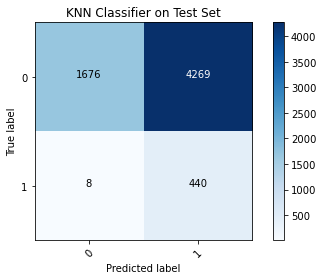

In [14]:
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=False,
                                              do_lem=False, 
                                              split=True,
                                              upsample=False,
                                              do_emojis=True)


X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test)
# SMOTE
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(X_train.toarray(), y_train)


#oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
knn = KNN_DM()
model = knn.fit(oversampled_X, oversampled_Y, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
print()

2022-05-26 15:01:09,927 WARNING Using custom data configuration default
2022-05-26 15:01:09,970 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)
----------------------------------------------------------------------------------------------------



function: 'fit' finished in 4.33 seconds.
----------------------------------------------------------------------------------------------------


head of y_pred is 	[1 1 1 1 1 1]: 
function: 'predict' finished in 125.42 seconds.
----------------------------------------------------------------------------------------------------


f1-score:         	0.16679418515684777 
accuracy-score:   	31.862975129047395 
precision-score:  	0.09121338912133892 
recall-score:     	0.9732142857142857 

----------------------------------------------------------------------------------------------------


precision    recall  f1-score     support
0              0.992560  0.269302  0.423657  5945.00000
1              0.091213  0.973214  0.166794   448.00000
accuracy       0.318630  0.318630  0.318630     0.31863
macro avg      0.541887  0.621258  0.295226  6393.00000
weighted avg   0.929397  0.318630  0.405657  6393.00000


function: 'print_report' finished in 0.04 seconds.
----------------------------------------------------------------------------------------------------


Start plotting the confusion matrix...

function: '__plot_confusion_matrix' finished in 0.11 seconds.
function: 'evaluate' finished in 0.17 seconds.



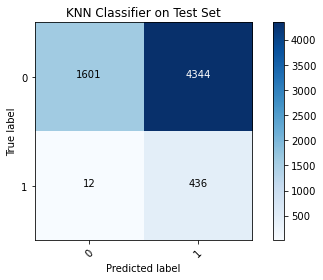

In [15]:
X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=False)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train

# SMOTE
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(X_train.toarray(), y_train)


#oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
knn = KNN_DM()
model = knn.fit(oversampled_X, oversampled_Y, optim=False)
y_pred = model.predict(X_test.toarray(), y_test)
report, accuracy, recall, precision, f1 = model.evaluate()
print()

### Moving threshold 

almost each classifier in sklearn has predict_proba, and it is by default assigning 0.5 probability for each class
in the the case of imbalanced class, this is not the  fall, so we try to find a better value than the default one.

In [46]:
from sklearn.metrics import roc_auc_score
knn = KNeighborsClassifier()

knn.fit(X_train,y_train)   
knn.predict_proba(X_test) #probability of the class label
step_factor = 0.05 
threshold_value = 0.2 
roc_score=0
predicted_proba = knn.predict_proba(X_test_c.toarray()) #probability of prediction
while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted): #store the threshold for best classification
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor
print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.2 -- 0.7743707196924186
Threshold 0.25 -- 0.6876043794304939
Threshold 0.3 -- 0.6876043794304939
Threshold 0.35 -- 0.6876043794304939
Threshold 0.39999999999999997 -- 0.6876043794304939
Threshold 0.44999999999999996 -- 0.6205584299531419
Threshold 0.49999999999999994 -- 0.6205584299531419
Threshold 0.5499999999999999 -- 0.6205584299531419
Threshold 0.6 -- 0.6205584299531419
Threshold 0.65 -- 0.5879173299891867
Threshold 0.7000000000000001 -- 0.5879173299891867
Threshold 0.7500000000000001 -- 0.5879173299891867
---Optimum Threshold --- 0.2 --ROC-- 0.7743707196924186


In [47]:
#knn = KNeighborsClassifier()
#knn.fit(X_train_c.toarray(),y_train)
#y_pred = knn.predict(X_test_c.toarray())  # default threshold is 0.5

y_pred = (knn.predict_proba(X_test.toarray())[:,1] >= 0.2).astype(bool) # set threshold as 0.2

In [48]:
f1 = f1_score(y_test, y_pred);
print("f1 after changing the threshold: ", f1)

f1 after changing the threshold:  0.22758343385605145


# Boosting

uses wisdom of the crowd
train multiple classifers and use weighted Vote (classifiers have either confidence score or estimate error)


could be used for imbalanced problems by assigning smaller weights for bigger classes

In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


bdt = AdaBoostClassifier(
                    DecisionTreeClassifier(),
                    n_estimators=10)

# Train Adaboost Classifer
model = bdt.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [57]:
f1 = f1_score(y_test, y_pred);
print("f1 after boosting: ", f1)

f1 after boosting:  0.5227272727272728


In [61]:
!pip install mlens

Looking in indexes: https://int.repositories.cloud.sap/artifactory/api/pypi/build-releases-pypi/simple, https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/simple
  Using cached https://int.repositories.cloud.sap/artifactory/api/pypi/build-milestones-pypi/packages/packages/0b/f7/c04bda423ac93ddb54bc4c3a21c79c9a24bc83844efc30dc4c11c289e894/mlens-0.2.3-py2.py3-none-any.whl (227 kB)


### Stacking

Wisdom of the crowd
like boosting, Differenece: it uses another classifier for making the last prediction, instead of voting.

it uses multiple base-learners take thier predictions and pass them as features for a meta-learner

In [10]:
from mlens.ensemble import SuperLearner
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix


X_train, X_test, y_train, y_test = featureize(rem_stop=True,
                                              do_stem=True,
                                              do_lem=False, 
                                              split=True,
                                              upsample=True,
                                              do_emojis=False)
X_train, X_test, X_train_c, X_test_c = convert_to_tf_idf(X_train, X_test); X_train


ensemble = SuperLearner(scorer=f1_score, verbose=0)
# Build the first layer
ensemble.add([KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_neighbors=2), SVC(C=5)])

# Attach the final meta estimator
ensemble.add_meta(DecisionTreeClassifier())

# Fit ensemble
ensemble.fit(X_train_c.toarray(),y_train)

# Predict
preds = ensemble.predict(X_test_c)

print(classification_report(y_test,preds))
#print("Fit data:\n%r" % ensemble.data)
#print("Prediction score: %.3f" % accuracy_score(y_test, preds)) 

2022-05-26 15:43:17,810 WARNING Using custom data configuration default
2022-05-26 15:43:17,816 WARNING Reusing dataset tweets_hate_speech_detection (C:\Users\D073999\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

X_train: 25569, X_test: 6393
(25569, 32129)
(25569, 32129)
(6393, 32129)
(6393, 32129)


JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...orch\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\runpy.py in _run_code(code=<code object <module> at 0x00000252B6BDC030, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\D073999\Miniconda3\envs\torch\lib\site-...ges\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...orch\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\D...ch\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...orch\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000252B6BDC030, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\D073999\Miniconda3\envs\torch\lib\site-...ges\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...orch\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\D...ch\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    841 
    842         If a global instance already exists, this reinitializes and starts it
    843         """
    844         app = cls.instance(**kwargs)
    845         app.initialize(argv)
--> 846         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    847 
    848 #-----------------------------------------------------------------------------
    849 # utility functions, for convenience
    850 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    672                 tr.run()
    673             except KeyboardInterrupt:
    674                 pass
    675         else:
    676             try:
--> 677                 self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    678             except KeyboardInterrupt:
    679                 pass
    680 
    681 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    194         except (RuntimeError, AssertionError):
    195             old_loop = None  # type: ignore
    196         try:
    197             self._setup_logging()
    198             asyncio.set_event_loop(self.asyncio_loop)
--> 199             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    200         finally:
    201             asyncio.set_event_loop(old_loop)
    202 
    203     def stop(self) -> None:

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    536         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    537                                finalizer=self._asyncgen_finalizer_hook)
    538         try:
    539             events._set_running_loop(self)
    540             while True:
--> 541                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    542                 if self._stopping:
    543                     break
    544         finally:
    545             self._stopping = False

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1781                         logger.warning('Executing %s took %.3f seconds',
   1782                                        _format_handle(handle), dt)
   1783                 finally:
   1784                     self._current_handle = None
   1785             else:
-> 1786                 handle._run()
        handle._run = <bound method Handle._run of <Handle <TaskWakeup...000252C840F588>(<Future finis...7C8>, ...],))>)>>
   1787         handle = None  # Needed to break cycles when an exception occurs.
   1788 
   1789     def _set_coroutine_origin_tracking(self, enabled):
   1790         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\asyncio\events.py in _run(self=<Handle <TaskWakeupMethWrapper object at 0x00000252C840F588>(<Future finis...7C8>, ...],))>)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <TaskWakeupMethWrapper object>
        self._args = (<Future finished result=(19, <bound method...025...001708>, <zmq.sugar.fr...00252BA0017C8>, ...],))>,)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py in dispatch_queue(self=<ipykernel.ipkernel.IPythonKernel object>)
    466         even when the handler is async
    467         """
    468 
    469         while True:
    470             try:
--> 471                 await self.process_one()
        self.process_one = <bound method Kernel.process_one of <ipykernel.ipkernel.IPythonKernel object>>
    472             except Exception:
    473                 self.log.exception("Error in message handler")
    474 
    475     _message_counter = Any(

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py in process_one(self=<ipykernel.ipkernel.IPythonKernel object>, wait=True)
    455         else:
    456             try:
    457                 t, dispatch, args = self.msg_queue.get_nowait()
    458             except (asyncio.QueueEmpty, QueueEmpty):
    459                 return None
--> 460         await dispatch(*args)
        dispatch = <bound method Kernel.dispatch_shell of <ipykernel.ipkernel.IPythonKernel object>>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
    461 
    462     async def dispatch_queue(self):
    463         """Coroutine to preserve order of message handling
    464 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2022, 5, 26, 13, 43, 16, 676000, tzinfo=tzutc()), 'msg_id': '46487243db234e59bf8353dc7babfe94', 'msg_type': 'execute_request', 'session': '956c4adc8301493ba2e99a72e80c26a5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '46487243db234e59bf8353dc7babfe94', 'msg_type': 'execute_request', 'parent_header': {}})
    362             except Exception:
    363                 self.log.debug("Unable to signal in pre_handler_hook:", exc_info=True)
    364             try:
    365                 result = handler(self.shell_stream, idents, msg)
    366                 if inspect.isawaitable(result):
--> 367                     await result
        result = <coroutine object Kernel.execute_request>
    368             except Exception:
    369                 self.log.error("Exception in message handler:", exc_info=True)
    370             except KeyboardInterrupt:
    371                 # Ctrl-c shouldn't crash the kernel here.

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'956c4adc8301493ba2e99a72e80c26a5'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2022, 5, 26, 13, 43, 16, 676000, tzinfo=tzutc()), 'msg_id': '46487243db234e59bf8353dc7babfe94', 'msg_type': 'execute_request', 'session': '956c4adc8301493ba2e99a72e80c26a5', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '46487243db234e59bf8353dc7babfe94', 'msg_type': 'execute_request', 'parent_header': {}})
    657         reply_content = self.do_execute(
    658             code, silent, store_history,
    659             user_expressions, allow_stdin,
    660         )
    661         if inspect.isawaitable(reply_content):
--> 662             reply_content = await reply_content
        reply_content = <coroutine object IPythonKernel.do_execute>
    663 
    664         # Flush output before sending the reply.
    665         sys.stdout.flush()
    666         sys.stderr.flush()

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    355                             shell.events.trigger('post_run_cell', res)
    356             else:
    357                 # runner isn't already running,
    358                 # make synchronous call,
    359                 # letting shell dispatch to loop runners
--> 360                 res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        code = 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) '
        store_history = True
        silent = False
    361         finally:
    362             self._restore_input()
    363 
    364         if res.error_before_exec is not None:

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ',), **kwargs={'silent': False, 'store_history': True})
    527         )
    528         self.payload_manager.write_payload(payload)
    529 
    530     def run_cell(self, *args, **kwargs):
    531         self._last_traceback = None
--> 532         return super().run_cell(*args, **kwargs)
        args = ('from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ',)
        kwargs = {'silent': False, 'store_history': True}
    533 
    534     def _showtraceback(self, etype, evalue, stb):
    535         # try to preserve ordering of tracebacks and print statements
    536         sys.stdout.flush()

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', store_history=True, silent=False, shell_futures=True)
   2910         result : :class:`ExecutionResult`
   2911         """
   2912         result = None
   2913         try:
   2914             result = self._run_cell(
-> 2915                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) '
        store_history = True
        silent = False
        shell_futures = True
   2916         finally:
   2917             self.events.trigger('post_execute')
   2918             if not silent:
   2919                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', store_history=True, silent=False, shell_futures=True)
   2955             runner = self.loop_runner
   2956         else:
   2957             runner = _pseudo_sync_runner
   2958 
   2959         try:
-> 2960             return runner(coro)
        runner = <function _pseudo_sync_runner>
        coro = <coroutine object InteractiveShell.run_cell_async>
   2961         except BaseException as e:
   2962             info = ExecutionInfo(raw_cell, store_history, silent, shell_futures)
   2963             result = ExecutionResult(info)
   2964             result.error_in_exec = e

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\IPython\core\async_helpers.py in _pseudo_sync_runner(coro=<coroutine object InteractiveShell.run_cell_async>)
     73 
     74     Credit to Nathaniel Smith
     75 
     76     """
     77     try:
---> 78         coro.send(None)
        coro.send = <built-in method send of coroutine object>
     79     except StopIteration as exc:
     80         return exc.value
     81     else:
     82         # TODO: do not raise but return an execution result with the right info.

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py in run_cell_async(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', store_history=True, silent=False, shell_futures=True, transformed_cell='from mlens.ensemble import SuperLearner\nfrom skl...n score: %.3f" % accuracy_score(y_test, preds)) \n', preprocessing_exc_tuple=None)
   3181                 interactivity = "none" if silent else self.ast_node_interactivity
   3182                 if _run_async:
   3183                     interactivity = 'async'
   3184 
   3185                 has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
-> 3186                        interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <ipykernel.compiler.XCachingCompiler object>
   3187 
   3188                 self.last_execution_succeeded = not has_raised
   3189                 self.last_execution_result = result
   3190 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>], cell_name=r'C:\Users\D073999\AppData\Local\Temp\ipykernel_21464\3287195673.py', interactivity='last', compiler=<ipykernel.compiler.XCachingCompiler object>, result=<ExecutionResult object at 252c87611c8, executio...rue silent=False shell_futures=True> result=None>)
   3372                     elif mode == 'single':
   3373                         mod = ast.Interactive([node])
   3374                     with compiler.extra_flags(getattr(ast, 'PyCF_ALLOW_TOP_LEVEL_AWAIT', 0x0) if self.autoawait else 0x0):
   3375                         code = compiler(mod, cell_name, mode)
   3376                         asy = compare(code)
-> 3377                     if (await self.run_code(code, result,  async_=asy)):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x00000252C9893DB0, fil...cal\Temp\ipykernel_21464\3287195673.py", line 25>
        result = <ExecutionResult object at 252c87611c8, executio...rue silent=False shell_futures=True> result=None>
        asy = False
   3378                         return True
   3379 
   3380             # Flush softspace
   3381             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x00000252C9893DB0, fil...cal\Temp\ipykernel_21464\3287195673.py", line 25>, result=<ExecutionResult object at 252c87611c8, executio...rue silent=False shell_futures=True> result=None>, async_=False)
   3452                     code = compile('last_expr', 'fake', "single")
   3453                     exec(code, {'last_expr': last_expr})
   3454                 elif async_ :
   3455                     await eval(code_obj, self.user_global_ns, self.user_ns)
   3456                 else:
-> 3457                     exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x00000252C9893DB0, fil...cal\Temp\ipykernel_21464\3287195673.py", line 25>
        self.user_global_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'Boolean': <class 'bool'>, 'ClassifierMixin': <class 'sklearn.base.ClassifierMixin'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DecisionTreeClassifier': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'In': ['', "# import libraries\nimport seaborn as sns\nimport ...import warnings\nwarnings.filterwarnings('ignore')", "get_ipython().system('pip install demoji')", '# Just in case the file structure does not make ...mpile(r"#(\\w+)")\n    return pattern.findall(text)', "import sys  \nsys.path.insert(0, 'C:\\\\Users\\\\D073..._emoji, setup\n#from src.data import preprocessing", 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', 'import functools\nimport time\n\n\ndef time_decorate...       return result\n\n    return time_measurement', "class KNN_DM(BaseEstimator, ClassifierMixin):\n  ...bel('Predicted label')\n        plt.tight_layout()", "def featureize(rem_stop=False, do_stem=False, do...t)}')\n    return X_train, X_test, y_train, y_test", 'def convert_to_tf_idf(X_train, X_test):\n    \n   ...f, x_test_tfidf, x_train_counts, x_test_counts   ', 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) '], 'KNN_DM': <class '__main__.KNN_DM'>, 'KNeighborsClassifier': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, ...}
        self.user_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'Boolean': <class 'bool'>, 'ClassifierMixin': <class 'sklearn.base.ClassifierMixin'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'DecisionTreeClassifier': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'HTML': <class 'IPython.core.display.HTML'>, 'In': ['', "# import libraries\nimport seaborn as sns\nimport ...import warnings\nwarnings.filterwarnings('ignore')", "get_ipython().system('pip install demoji')", '# Just in case the file structure does not make ...mpile(r"#(\\w+)")\n    return pattern.findall(text)', "import sys  \nsys.path.insert(0, 'C:\\\\Users\\\\D073..._emoji, setup\n#from src.data import preprocessing", 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) ', 'import functools\nimport time\n\n\ndef time_decorate...       return result\n\n    return time_measurement', "class KNN_DM(BaseEstimator, ClassifierMixin):\n  ...bel('Predicted label')\n        plt.tight_layout()", "def featureize(rem_stop=False, do_stem=False, do...t)}')\n    return X_train, X_test, y_train, y_test", 'def convert_to_tf_idf(X_train, X_test):\n    \n   ...f, x_test_tfidf, x_train_counts, x_test_counts   ', 'from mlens.ensemble import SuperLearner\nfrom skl...on score: %.3f" % accuracy_score(y_test, preds)) '], 'KNN_DM': <class '__main__.KNN_DM'>, 'KNeighborsClassifier': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, ...}
   3458             finally:
   3459                 # Reset our crash handler in place
   3460                 sys.excepthook = old_excepthook
   3461         except SystemExit as e:

...........................................................................
C:\Users\D073999\AppData\Local\Temp\ipykernel_21464\3287195673.py in <module>()
     20 
     21 # Attach the final meta estimator
     22 ensemble.add_meta(DecisionTreeClassifier())
     23 
     24 # Fit ensemble
---> 25 ensemble.fit(X_train_c.toarray(),y_train)
     26 
     27 # Predict
     28 preds = ensemble.predict(X_test_c)
     29 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\ensemble\base.py in fit(self=SuperLearner(array_check=None, backend=None, fol...000252BF7B7D38>, shuffle=False,
       verbose=0), X=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), y=30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64, **kwargs={})
    509             return self
    510 
    511         if self.model_selection:
    512             self._id_train.fit(X)
    513 
--> 514         out = self._backend.fit(X, y, **kwargs)
        out = undefined
        self._backend.fit = <bound method Sequential.fit of Sequential(backe...nsformers=[])],
   verbose=0)],
      verbose=0)>
        X = array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
        y = 30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64
        kwargs = {}
    515         if out is not self._backend:
    516             # fit_transform
    517             return out
    518         else:

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\ensemble\base.py in fit(self=Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=0)],
      verbose=0), X=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), y=30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64, **kwargs={})
    153 
    154         f, t0 = print_job(self, "Fitting")
    155 
    156         with ParallelProcessing(self.backend, self.n_jobs,
    157                                 max(self.verbose - 4, 0)) as manager:
--> 158             out = manager.stack(self, 'fit', X, y, **kwargs)
        out = undefined
        manager.stack = <bound method ParallelProcessing.stack of <mlens.parallel.backend.ParallelProcessing object>>
        self = Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=0)],
      verbose=0)
        X = array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
        y = 30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64
        kwargs = {}
    159 
    160         if self.verbose:
    161             print_time(t0, "{:<35}".format("Fit complete"), file=f)
    162 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\backend.py in stack(self=<mlens.parallel.backend.ParallelProcessing object>, caller=Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=0)],
      verbose=0), job='fit', X=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), y=30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64, path=None, return_preds=False, warm_start=False, split=True, **kwargs={})
    668             Prediction array(s).
    669         """
    670         out = self.initialize(
    671             job=job, X=X, y=y, path=path, warm_start=warm_start,
    672             return_preds=return_preds, split=split, stack=True)
--> 673         return self.process(caller=caller, out=out, **kwargs)
        self.process = <bound method ParallelProcessing.process of <mlens.parallel.backend.ParallelProcessing object>>
        caller = Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=0)],
      verbose=0)
        out = {}
        kwargs = {}
    674 
    675     def process(self, caller, out, **kwargs):
    676         """Process job.
    677 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\backend.py in process(self=<mlens.parallel.backend.ParallelProcessing object>, caller=Sequential(backend='threading', dtype=<class 'nu...ansformers=[])],
   verbose=0)],
      verbose=0), out=None, **kwargs={})
    713                       backend=self.backend) as parallel:
    714 
    715             for task in caller:
    716                 self.job.clear()
    717 
--> 718                 self._partial_process(task, parallel, **kwargs)
        self._partial_process = <bound method ParallelProcessing._partial_proces...lens.parallel.backend.ParallelProcessing object>>
        task = Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=0)
        parallel = Parallel(n_jobs=-1)
        kwargs = {}
    719 
    720                 if task.name in return_names:
    721                     out.append(self.get_preds(dtype=_dtype(task)))
    722 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\backend.py in _partial_process(self=<mlens.parallel.backend.ParallelProcessing object>, task=Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=0), parallel=Parallel(n_jobs=-1), **kwargs={})
    734         task.setup(self.job.predict_in, self.job.targets, self.job.job)
    735 
    736         if not task.__no_output__:
    737             self._gen_prediction_array(task, self.job.job, self.__threading__)
    738 
--> 739         task(self.job.args(**kwargs), parallel=parallel)
        task = Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=0)
        self.job.args = <bound method Job.args of <mlens.parallel.backend.Job object>>
        kwargs = {}
        parallel = Parallel(n_jobs=-1)
    740 
    741         if not task.__no_output__ and getattr(task, 'n_feature_prop', 0):
    742             self._propagate_features(task)
    743 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\layer.py in __call__(self=Layer(backend='threading', dtype=<class 'numpy.f..._exception=True, transformers=[])],
   verbose=0), args={'auxiliary': {'P': None, 'X': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 'y': 30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64}, 'dir': [('kneighborsclassifier.0.0', <mlens.parallel.learner.IndexedEstimator object>)], 'job': 'fit', 'main': {'P': array([[0., 0.],
       [0., 0.],
       [0., 0....       [0., 0.],
       [0., 0.]], dtype=float32), 'X': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 'y': 30405    0
27807    0
8660     0
19185    0
1035...850    0
Name: label, Length: 25569, dtype: int64}}, parallel=Parallel(n_jobs=-1))
    147         if self.verbose >= 2:
    148             safe_print(msg.format('Learners ...'), file=f, end=e2)
    149             t1 = time()
    150 
    151         parallel(delayed(sublearner, not _threading)()
--> 152                  for learner in self.learners
        self.learners = [Learner(attr='predict', backend='threading', dty...scorer=<function f1_score at 0x00000252BF7B7D38>), Learner(attr='predict', backend='threading', dty...scorer=<function f1_score at 0x00000252BF7B7D38>)]
    153                  for sublearner in learner(args, 'main'))
    154 
    155         if self.verbose >= 2:
    156             print_time(t1, 'done', file=f)

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object Layer.__call__.<locals>.<genexpr>>)
    788             if pre_dispatch == "all" or n_jobs == 1:
    789                 # The iterable was consumed all at once by the above for loop.
    790                 # No need to wait for async callbacks to trigger to
    791                 # consumption.
    792                 self._iterating = False
--> 793             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    794             # Make sure that we get a last message telling us we are done
    795             elapsed_time = time.time() - self._start_time
    796             self._print('Done %3i out of %3i | elapsed: %s finished',
    797                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Thu May 26 15:46:53 2022
PID: 21464 Python 3.7.13: C:\Users\D073999\Miniconda3\envs\torch\python.exe
...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\externals\joblib\parallel.py in __call__(self=<mlens.externals.joblib.parallel.BatchedCalls object>)
    130     def __init__(self, iterator_slice):
    131         self.items = list(iterator_slice)
    132         self._size = len(self.items)
    133 
    134     def __call__(self):
--> 135         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<mlens.parallel.learner.SubLearner object>, (), {})]
    136 
    137     def __len__(self):
    138         return self._size
    139 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    130     def __init__(self, iterator_slice):
    131         self.items = list(iterator_slice)
    132         self._size = len(self.items)
    133 
    134     def __call__(self):
--> 135         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <mlens.parallel.learner.SubLearner object>
        args = ()
        kwargs = {}
    136 
    137     def __len__(self):
    138         return self._size
    139 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\learner.py in __call__(self=<mlens.parallel.learner.SubLearner object>)
    119         else:
    120             self.processing_index = ''
    121 
    122     def __call__(self):
    123         """Launch job"""
--> 124         return getattr(self, self.job)()
        self = <mlens.parallel.learner.SubLearner object>
        self.job = 'fit'
    125 
    126     def fit(self, path=None):
    127         """Fit sub-learner"""
    128         if path is None:

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\learner.py in fit(self=<mlens.parallel.learner.SubLearner object>, path=[('kneighborsclassifier.0.0', <mlens.parallel.learner.IndexedEstimator object>)])
    131         transformers = self._load_preprocess(path)
    132 
    133         self._fit(transformers)
    134 
    135         if self.out_array is not None:
--> 136             self._predict(transformers, self.scorer is not None)
        self._predict = <bound method SubLearner._predict of <mlens.parallel.learner.SubLearner object>>
        transformers = None
        self.scorer = <function f1_score>
    137 
    138         o = IndexedEstimator(estimator=self.estimator,
    139                              name=self.name_index,
    140                              index=self.index,

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\mlens\parallel\learner.py in _predict(self=<mlens.parallel.learner.SubLearner object>, transformers=None, score_preds=True)
    194         xtemp, ytemp = slice_array(self.in_array, self.targets, self.out_index)
    195         t0 = time()
    196 
    197         if transformers:
    198             xtemp, ytemp = transformers.transform(xtemp, ytemp)
--> 199         predictions = getattr(self.estimator, self.attr)(xtemp)
        predictions = undefined
        self.estimator = KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_neighbors=2)
        self.attr = 'predict'
        xtemp = array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
    200 
    201         self.pred_time_ = time() - t0
    202 
    203         # Assign predictions to matrix

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\sklearn\neighbors\_classification.py in predict(self=KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_neighbors=2), X=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64))
    209         Returns
    210         -------
    211         y : ndarray of shape (n_queries,) or (n_queries, n_outputs)
    212             Class labels for each data sample.
    213         """
--> 214         neigh_dist, neigh_ind = self.kneighbors(X)
        neigh_dist = undefined
        neigh_ind = undefined
        self.kneighbors = <bound method KNeighborsMixin.kneighbors of KNei...gorithm='ball_tree', metric='l1', n_neighbors=2)>
        X = array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
    215         classes_ = self.classes_
    216         _y = self._y
    217         if not self.outputs_2d_:
    218             _y = self._y.reshape((-1, 1))

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\sklearn\neighbors\_base.py in kneighbors(self=KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_neighbors=2), X=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), n_neighbors=2, return_distance=True)
    775                 parallel_kwargs = {"prefer": "threads"}
    776             chunked_results = Parallel(n_jobs, **parallel_kwargs)(
    777                 delayed(_tree_query_parallel_helper)(
    778                     self._tree, X[s], n_neighbors, return_distance
    779                 )
--> 780                 for s in gen_even_slices(X.shape[0], n_jobs)
        X.shape = (12785, 32129)
        n_jobs = 1
    781             )
    782         else:
    783             raise ValueError("internal: _fit_method not recognized")
    784 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object KNeighborsMixin.kneighbors.<locals>.<genexpr>>)
   1038             # self._original_iterator is None, then this means either
   1039             # that pre_dispatch == "all", n_jobs == 1 or that the first batch
   1040             # was very quick and its callback already dispatched all the
   1041             # remaining jobs.
   1042             self._iterating = False
-> 1043             if self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object KNeighborsMixin.kneighbors.<locals>.<genexpr>>
   1044                 self._iterating = self._original_iterator is not None
   1045 
   1046             while self.dispatch_one_batch(iterator):
   1047                 pass

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object KNeighborsMixin.kneighbors.<locals>.<genexpr>>)
    856                 tasks = self._ready_batches.get(block=False)
    857             if len(tasks) == 0:
    858                 # No more tasks available in the iterator: tell caller to stop.
    859                 return False
    860             else:
--> 861                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <joblib.parallel.BatchedCalls object>
    862                 return True
    863 
    864     def _print(self, msg, msg_args):
    865         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<joblib.parallel.BatchedCalls object>)
    774 
    775         dispatch_timestamp = time.time()
    776         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
    777         with self._lock:
    778             job_idx = len(self._jobs)
--> 779             job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <joblib._parallel_backends.SequentialBackend object>>
        batch = <joblib.parallel.BatchedCalls object>
        cb = <joblib.parallel.BatchCompletionCallBack object>
    780             # A job can complete so quickly than its callback is
    781             # called before we get here, causing self._jobs to
    782             # grow. To ensure correct results ordering, .insert is
    783             # used (rather than .append) in the following line

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\_parallel_backends.py in apply_async(self=<joblib._parallel_backends.SequentialBackend object>, func=<joblib.parallel.BatchedCalls object>, callback=<joblib.parallel.BatchCompletionCallBack object>)
    203             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    204         return 1
    205 
    206     def apply_async(self, func, callback=None):
    207         """Schedule a func to be run"""
--> 208         result = ImmediateResult(func)
        result = undefined
        func = <joblib.parallel.BatchedCalls object>
    209         if callback:
    210             callback(result)
    211         return result
    212 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\_parallel_backends.py in __init__(self=<joblib._parallel_backends.ImmediateResult object>, batch=<joblib.parallel.BatchedCalls object>)
    567 
    568 class ImmediateResult(object):
    569     def __init__(self, batch):
    570         # Don't delay the application, to avoid keeping the input
    571         # arguments in memory
--> 572         self.results = batch()
        self.results = undefined
        batch = <joblib.parallel.BatchedCalls object>
    573 
    574     def get(self):
    575         return self.results
    576 

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    258     def __call__(self):
    259         # Set the default nested backend to self._backend but do not set the
    260         # change the default number of processes to -1
    261         with parallel_backend(self._backend, n_jobs=self._n_jobs):
    262             return [func(*args, **kwargs)
--> 263                     for func, args, kwargs in self.items]
        self.items = [(<sklearn.utils.fixes._FuncWrapper object>, (<sklearn.neighbors._ball_tree.BallTree object>, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 2, True), {})]
    264 
    265     def __reduce__(self):
    266         if self._reducer_callback is not None:
    267             self._reducer_callback()

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    258     def __call__(self):
    259         # Set the default nested backend to self._backend but do not set the
    260         # change the default number of processes to -1
    261         with parallel_backend(self._backend, n_jobs=self._n_jobs):
    262             return [func(*args, **kwargs)
--> 263                     for func, args, kwargs in self.items]
        func = <sklearn.utils.fixes._FuncWrapper object>
        args = (<sklearn.neighbors._ball_tree.BallTree object>, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 2, True)
        kwargs = {}
    264 
    265     def __reduce__(self):
    266         if self._reducer_callback is not None:
    267             self._reducer_callback()

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\sklearn\utils\fixes.py in __call__(self=<sklearn.utils.fixes._FuncWrapper object>, *args=(<sklearn.neighbors._ball_tree.BallTree object>, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 2, True), **kwargs={})
    211         self.config = get_config()
    212         update_wrapper(self, self.function)
    213 
    214     def __call__(self, *args, **kwargs):
    215         with config_context(**self.config):
--> 216             return self.function(*args, **kwargs)
        self.function = <function _tree_query_parallel_helper>
        args = (<sklearn.neighbors._ball_tree.BallTree object>, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 2, True)
        kwargs = {}
    217 
    218 
    219 def linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0):
    220     """Implements a simplified linspace function as of numpy version >= 1.16.

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\sklearn\neighbors\_base.py in _tree_query_parallel_helper(tree=<sklearn.neighbors._ball_tree.BallTree object>, *args=(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 2, True), **kwargs={})
    595     """Helper for the Parallel calls in KNeighborsMixin.kneighbors.
    596 
    597     The Cython method tree.query is not directly picklable by cloudpickle
    598     under PyPy.
    599     """
--> 600     return tree.query(*args, **kwargs)
        tree.query = <built-in method query of sklearn.neighbors._ball_tree.BallTree object>
        args = (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), 2, True)
        kwargs = {}
    601 
    602 
    603 class KNeighborsMixin:
    604     """Mixin for k-neighbors searches."""

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\sklearn\neighbors\_ball_tree.cp37-win_amd64.pyd in sklearn.neighbors._ball_tree.BinaryTree.query()

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\sklearn\utils\validation.py in check_array(array=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), accept_sparse=False, accept_large_sparse=True, dtype=<class 'numpy.float64'>, order='C', copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, estimator=None)
    741                     array = np.asarray(array, order=order)
    742                     if array.dtype.kind == "f":
    743                         _assert_all_finite(array, allow_nan=False, msg_dtype=dtype)
    744                     array = array.astype(dtype, casting="unsafe", copy=False)
    745                 else:
--> 746                     array = np.asarray(array, order=order, dtype=dtype)
        array = array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
        order = 'C'
        dtype = <class 'numpy.float64'>
    747             except ComplexWarning as complex_warning:
    748                 raise ValueError(
    749                     "Complex data not supported\n{}\n".format(array)
    750                 ) from complex_warning

...........................................................................
C:\Users\D073999\Miniconda3\envs\torch\lib\site-packages\numpy\core\_asarray.py in asarray(a=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), dtype=<class 'numpy.float64'>, order='C')
     78     False
     79     >>> np.asanyarray(a) is a
     80     True
     81 
     82     """
---> 83     return array(a, dtype, copy=False, order=order)
        a = array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0,...0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)
        dtype = <class 'numpy.float64'>
        order = 'C'
     84 
     85 
     86 @set_module('numpy')
     87 def asanyarray(a, dtype=None, order=None):

MemoryError: Unable to allocate 3.06 GiB for an array with shape (12785, 32129) and data type float64
___________________________________________________________________________